In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pyproj
import seaborn as sns
from random import shuffle, randint
from tqdm import tqdm
from sklearn.neighbors import BallTree,KDTree
from sklearn.neighbors import DistanceMetric
from sklearn.metrics.pairwise import haversine_distances, euclidean_distances
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from math import radians
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split 
pd.set_option('display.max_columns', None)
from scipy.spatial import distance_matrix
from verstack.stratified_continuous_split import scsplit
from lightgbm import LGBMRegressor,LGBMClassifier
from sklearn.inspection import permutation_importance
from pyproj import Proj, transform


from keras import Model
from tensorflow import keras
from keras.layers import Dense, Input
from keras.wrappers.scikit_learn import KerasRegressor
from keras.callbacks import EarlyStopping
from random import randint
from sklearn.ensemble import VotingRegressor
import tensorflow as tf 
from keras.models import Sequential
from keras.layers import Dropout, BatchNormalization
from math import radians,degrees

import folium
from folium.plugins import HeatMap
import branca
import branca.colormap as cm

import pickle


Using TensorFlow backend.


In [2]:
DEPARTMENT = 'marseille'

In [3]:
df = pd.read_csv('../Datas/Processed_data/{}.csv'.format(DEPARTMENT))
df['longitude_real'] = df.longitude.apply(degrees)
df['latitude_real'] = df.latitude.apply(degrees)

In [4]:
df

id_mutation nature_mutation  valeur_fonciere  code_postal  code_commune  \
0      2014-94503           Vente         192300.0      13001.0         13201   
1      2014-94504           Vente          70000.0      13002.0         13202   
2      2014-94505           Vente          57500.0      13015.0         13215   
3      2014-94507           Vente         210000.0      13015.0         13215   
4      2014-94508           Vente         160000.0      13004.0         13204   
...           ...             ...              ...          ...           ...   
74131  2020-33330           Vente         234450.0      13011.0         13211   
74132  2020-33331           Vente         307420.0      13011.0         13211   
74133  2020-33332           Vente         107000.0      13013.0         13213   
74134  2020-33333           Vente         750000.0      13011.0         13211   
74135  2020-33342           Vente         474076.0      13011.0         13211   

       code_departement  type_local  surface_reelle_bati  \
0                    13         0.0                 76.0   
1                    13         0.0                 36.0   
2                    13         0.0                 69.0   
3                    13         1.0                 60.0   
4                    13         0.0                 78.0   
...                 ...         ...                  ...   
74131                13         0.0                 97.0   
74132                13         1.0                 78.0   
74133                13         0.0                 60.0   
74134                13         1.0                199.0   
74135                13         1.0                134.0   

       nombre_pieces_principales  surface_terrain  longitude  latitude  \
0                              3              0.0   0.094060  0.755819   
1                              1              0.0   0.093743  0.755865   
2                              3              0.0   0.093513  0.756609   
3                              3            395.0   0.093229  0.757049   
4                              3              0.0   0.094290  0.755897   
...                          ...              ...        ...       ...   
74131                          5              0.0   0.095417  0.755470   
74132                          4              0.0   0.094921  0.755566   
74133                          3              0.0   0.094934  0.756135   
74134                          5           1000.0   0.096242  0.755795   
74135                          6            613.0   0.096072  0.755635   

      type_local_str  year  quarter  month  Prix_m2_bati  Prix_m2_total  \
0        Appartement  2014        1      1   2530.263158    2530.263158   
1        Appartement  2014        1      1   1944.444444    1944.444444   
2        Appartement  2014        1      1    833.333333     833.333333   
3             Maison  2014        1      1   3500.000000     461.538462   
4        Appartement  2014        1      1   2051.282051    2051.282051   
...              ...   ...      ...    ...           ...            ...   
74131    Appartement  2020        2      5   2417.010309    2417.010309   
74132         Maison  2020        2      6   3941.282051    3941.282051   
74133    Appartement  2020        2      6   1783.333333    1783.333333   
74134         Maison  2020        2      6   3768.844221     625.521268   
74135         Maison  2020        2      6   3537.880597     634.639893   

       arrondissement  dist_min_lycee type_plus_proche_lycee  \
0                   1        0.240704                   C301   
1                   2        0.387282                   C301   
2                  15        0.246702                   C301   
3                  15        1.106154                   C302   
4                   4        0.790391                   C301   
...               ...             ...                    ...   
74131              11        0.170542                   C301   
74132     

In [5]:
# SEVERE OUTLIER, my be interesting to relaunch the NN voisinage conputation

In [6]:
df.dropna(inplace=True)
df = df[(df.Prix_m2_bati> 1000) & (df.Prix_m2_bati < 11000)].reset_index(drop=True)

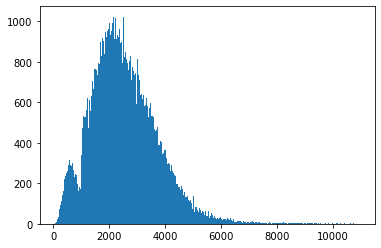

In [7]:
plt.hist(df.Prix_m2_total,bins=300);

# Adding specific datas

In fact, should be done in the produce_datasets script 

In [8]:
def add_speficic_datas(df) : 
    
    df_plages = pd.read_csv('../Datas/Raw_data/Marseille_datasets/marseille_bases_nautiques_plages_2018_vsohc0e.csv',
                    usecols=['Nom du site','Longitude','Latitude','Categorie'])
    
    df_plages.Latitude = df_plages.Latitude.apply(radians)
    df_plages.Longitude = df_plages.Longitude.apply(radians)
    
    plages = df_plages[df_plages.Categorie == 'Plages'].reset_index(drop=True)
    
    

    print("Calcul des plages les plus proches...")
    
    model = BallTree(plages[['Latitude', 'Longitude']].values, metric='haversine')
    dist, indices = model.query(df[['latitude', 'longitude']].values,5)
    dist *= 6371
    

    df['dist_min_plage'] = dist[:,0]
    df['mean_dist_2_plages'] = np.mean(dist[:,:2],axis=1)
    df['mean_dist_3_plages'] = np.mean(dist[:,:3],axis=1)
    df['mean_dist_5_plages'] = np.mean(dist[:,:5],axis=1)
    
    df['nom_plage_plus_proche'] = plages.loc[indices[:,0].squeeze(),'Nom du site'].values
    
    
    bn = df_plages[df_plages.Categorie == 'Bases nautiques'].reset_index(drop=True)
    
    

    print("Calcul de la base nautique la plus proche...")
    
    
    model = BallTree(bn[['Latitude', 'Longitude']].values, metric='haversine')
    dist, indices = model.query(df[['latitude', 'longitude']].values,1)
    dist *= 6371
    

    df['dist_min_bn'] = dist[:,0]
    
    df_parcs = pd.read_csv('../Datas/Raw_data/Marseille_datasets/marseille_parcs_jardins_2018.csv',
                    delimiter = '\t',usecols=['Nom du site','Longitude','Latitude'])
    
    df_parcs.Latitude = df_parcs.Latitude.apply(radians)
    df_parcs.Longitude = df_parcs.Longitude.apply(radians)
    
    
    print("Calcul de l'espace vert le plus proche")
    
    
    model = BallTree(df_parcs[['Latitude', 'Longitude']].values, metric='haversine')
    dist, indices = model.query(df[['latitude', 'longitude']].values,5)
    dist *= 6371
    
    df['dist_min_espace_vert'] = dist[:,0]
    df['mean_dist_5_espaces_verts'] = np.mean(dist,axis=1)
    
    
    df_monum = pd.read_csv('../Datas/Raw_data/Marseille_datasets/marseille_monuments_historiques_2018.csv',
                       delimiter = ';',usecols=['Longitude','Latitude']).dropna(subset=['Longitude','Latitude'])
    
    df_monum.Latitude = df_monum.Latitude.apply(radians)
    df_monum.Longitude = df_monum.Longitude.apply(radians)
    
    print("Calcul du monument le plus proche")
    
    
    model = BallTree(df_monum[['Latitude', 'Longitude']].values, metric='haversine')
    dist, indices = model.query(df[['latitude', 'longitude']].values,5)
    dist *= 6371
    
    df['dist_min_monument_historique'] = dist[:,0]
    df['mean_dist_5_monuments_historiques'] = np.mean(dist,axis=1)
    
    
    df_culture = pd.read_csv('../Datas/Raw_data/Marseille_datasets/marseille_lieux_culturels_2018_jrvozrd.csv',
                       delimiter = '\t',usecols=['Longitude','Latitude']).dropna(subset=['Longitude','Latitude'])
    
    df_culture.Latitude = df_culture.Latitude.apply(radians)
    df_culture.Longitude = df_culture.Longitude.apply(radians)
    
    
    print("Calcul du lieu culturel le plus proche")
    
    
    model = BallTree(df_culture[['Latitude', 'Longitude']].values, metric='haversine')
    dist, indices = model.query(df[['latitude', 'longitude']].values,5)
    dist *= 6371
    
    df['dist_min_culture'] = dist[:,0]
    df['mean_dist_5_lieux_culturels'] = np.mean(dist,axis=1)
    
    print("Now, adding economical datas about employement and demography per arrondissement...")
    # Adding pauverty for each arrondissement
    
    df_arr = pd.read_excel('../Datas/Raw_data/FILOSOFI_datasets/pauvrete_2018.xlsx')
    df_arr = df_arr[df_arr['Code géographique'].isin(df.code_commune.astype(str))].reset_index(drop=True).drop(
                    columns = ['Libellé géographique']).rename(columns = {'Code géographique' : 'code_commune'})
    
    df.code_commune = df.code_commune.astype(str)
    df = df.merge(df_arr,on='code_commune',how='left')
    
    
    
    print("Done.")
    
    
    
    return df

In [9]:
df = add_speficic_datas(df)

Calcul des plages les plus proches...
Calcul de la base nautique la plus proche...
Calcul de l'espace vert le plus proche
Calcul du monument le plus proche
Calcul du lieu culturel le plus proche
Now, adding economical datas about employement and demography per arrondissement...
Done.


In [10]:
df

id_mutation nature_mutation  valeur_fonciere  code_postal code_commune  \
0      2014-94503           Vente         192300.0      13001.0        13201   
1      2014-94504           Vente          70000.0      13002.0        13202   
2      2014-94507           Vente         210000.0      13015.0        13215   
3      2014-94508           Vente         160000.0      13004.0        13204   
4      2014-94509           Vente          90000.0      13003.0        13203   
...           ...             ...              ...          ...          ...   
70637  2020-33330           Vente         234450.0      13011.0        13211   
70638  2020-33331           Vente         307420.0      13011.0        13211   
70639  2020-33332           Vente         107000.0      13013.0        13213   
70640  2020-33333           Vente         750000.0      13011.0        13211   
70641  2020-33342           Vente         474076.0      13011.0        13211   

       code_departement  type_local  surface_reelle_bati  \
0                    13         0.0                 76.0   
1                    13         0.0                 36.0   
2                    13         1.0                 60.0   
3                    13         0.0                 78.0   
4                    13         0.0                 40.0   
...                 ...         ...                  ...   
70637                13         0.0                 97.0   
70638                13         1.0                 78.0   
70639                13         0.0                 60.0   
70640                13         1.0                199.0   
70641                13         1.0                134.0   

       nombre_pieces_principales  surface_terrain  longitude  latitude  \
0                              3              0.0   0.094060  0.755819   
1                              1              0.0   0.093743  0.755865   
2                              3            395.0   0.093229  0.757049   
3                              3              0.0   0.094290  0.755897   
4                              2              0.0   0.093912  0.756000   
...                          ...              ...        ...       ...   
70637                          5              0.0   0.095417  0.755470   
70638                          4              0.0   0.094921  0.755566   
70639                          3              0.0   0.094934  0.756135   
70640                          5           1000.0   0.096242  0.755795   
70641                          6            613.0   0.096072  0.755635   

      type_local_str  year  quarter  month  Prix_m2_bati  Prix_m2_total  \
0        Appartement  2014        1      1   2530.263158    2530.263158   
1        Appartement  2014        1      1   1944.444444    1944.444444   
2             Maison  2014        1      1   3500.000000     461.538462   
3        Appartement  2014        1      1   2051.282051    2051.282051   
4        Appartement  2014        1      1   2250.000000    2250.000000   
...              ...   ...      ...    ...           ...            ...   
70637    Appartement  2020        2      5   2417.010309    2417.010309   
70638         Maison  2020        2      6   3941.282051    3941.282051   
70639    Appartement  2020        2      6   1783.333333    1783.333333   
70640         Maison  2020        2      6   3768.844221     625.521268   
70641         Maison  2020        2      6   3537.880597     634.639893   

       arrondissement  dist_min_lycee type_plus_proche_lycee  \
0                   1        0.240704                   C301   
1                   2        0.387282                   C301   
2                  15        1.106154                   C302   
3                   4        0.790391                   C301   
4                   3        0.810458                   C302   
...               ...             ...                    ...   
70637              11        0.170542                   C301   
70638              11 

# Plot heat map of the price on the target city : 

In [11]:
# Takes a lot of memory, increase nb_plots for more details
# Static map after that

center = [43.300000, 5.400000]
nb_plots = 5e3

hmap = folium.Map(location= center, zoom_start=12)

max_price = float(df['Prix_m2_bati'].max())
min_price = float(df['Prix_m2_bati'].min())
colormap = cm.LinearColormap(colors=['blue','red'], vmin=min_price,vmax=max_price)



lat = list(df.loc[:nb_plots].latitude_real)
lon = list(df.loc[:nb_plots].longitude_real)
price = list(df.loc[:nb_plots].Prix_m2_bati)


for loc, p in tqdm(zip(zip(lat, lon), price)):
    folium.Circle(
        location=loc,
        radius=10,
        fill=True,
        color=colormap(p),
    ).add_to(hmap)
    
hmap.add_child(colormap)

display(hmap)

5001it [00:00, 18378.16it/s]


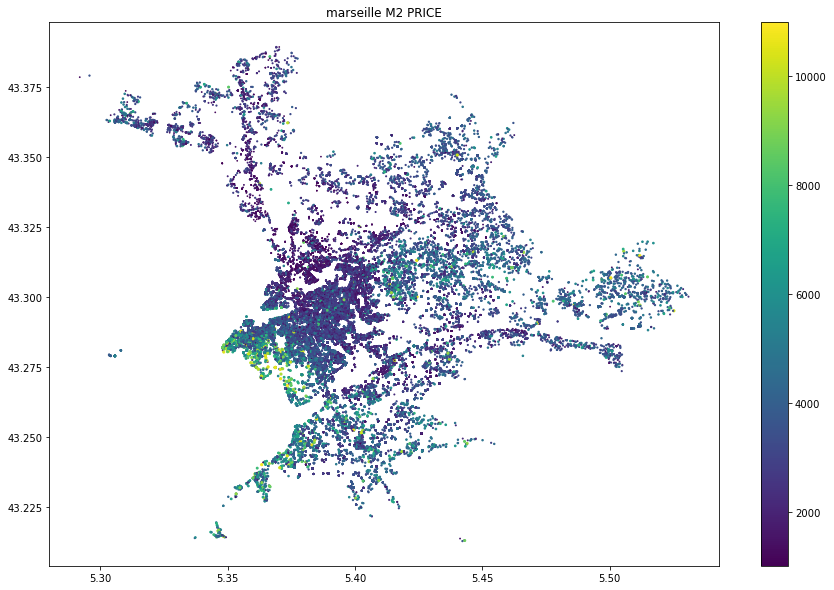

In [12]:
plt.figure(figsize = (15,10))
plt.scatter(df.longitude_real.values,df.latitude_real.values, c = df.Prix_m2_bati.values,s=5*df.Prix_m2_bati.values/df.Prix_m2_bati.values.max())
plt.colorbar()
plt.title('{} M2 PRICE'.format(DEPARTMENT))
plt.show()

In [13]:
from sklearn.metrics import mean_absolute_percentage_error
def evaluate_model(y_test,y_pred):
    error= np.abs((y_test-y_pred)/y_test)*100
    print('Mean absolute percentage error = {}'.format(mean_absolute_percentage_error(y_test,y_pred)*100))
    print('Median absolute percentage error = {}'.format(np.median(error)))

In [14]:
X_train, X_test, Y_train, Y_test = scsplit(df,df.Prix_m2_bati,test_size = 0.2,train_size = 0.8,stratify = df.valeur_fonciere,random_state=10)

In [15]:
index_train = X_train.index
index_test = X_test.index

prix_m2_train = Y_train.values
prix_m2_test = Y_test.values
vf_train = df.loc[index_train].valeur_fonciere
vf_test = df.loc[index_test].valeur_fonciere

In [16]:
categorical_features = ['nombre_pieces_principales','type_local','year','arrondissement',
                        'nom_plage_plus_proche']

quantitative_features = [
 'surface_reelle_bati',
 'surface_terrain',
 'dist_min_lycee',
 'dist_min_5_lycee',
 'dist_min_maternelle',
 'dist_min_ecoles_elementaires',
 'dist_min_colleges',
 'dist_min_5_colleges',
 'dist_min_sup',
 'dist_min_5_sup',
 'dist_min_supermarche',
 'dist_min_boulangerie',
 'dist_min_boucherie',
 'dist_min_poste',
 'dist_min_aeroport',
 'dist_min_culture',
 'dist_min_generaliste',
 'dist_min_banque',
 'dist_min_urgence',
 'dist_min_specialiste',
 'dist_min_dent',
 'dist_min_infirimier',
 'dist_min_creche',
 'dist_min_gare',
 'voisinage',
 'voisinage_total',
 'mean_dist_5_NN',
 'mean_dist_10_NN',
 'mean_dist_20_NN',
 'mean_dist_25_NN',
 'mean_dist_50_NN',
 'std_dist_5_NN',
 'std_dist_10_NN',
 'std_dist_20_NN',
 'std_dist_25_NN',
 'std_dist_50_NN',
 'dist_min_plage',
 'mean_dist_2_plages',
 'mean_dist_3_plages',
 'mean_dist_5_plages',
 'dist_min_bn',
 'dist_min_espace_vert',
 'mean_dist_5_espaces_verts',
 'dist_min_monument_historique',
 'mean_dist_5_monuments_historiques',
 'mean_dist_5_lieux_culturels',
    'Nombre de ménages fiscaux',
 'Médiane du niveau vie (€)',
 'Part des ménages fiscaux imposés (%)',
 'Taux de pauvreté-moins de 30 ans (%)',
 'Taux de pauvreté-locataires (%)',
 "Part des revenus d'activité (%)",
 'dont part des revenus des activités non salariées (%)',
 'Part des pensions, retraites et rentes (%)',
 'Part des revenus du patrimoine et autres revenus (%)',
 'dont part des prestations familiales (%)',
 'Rapport interdécile 9e décile/1er décile'
 ]

with open('./models/features_{}.txt'.format(DEPARTMENT), "wb") as fp:  
    pickle.dump([categorical_features + quantitative_features], fp)

X_train = X_train[categorical_features + quantitative_features]
X_test = X_test[categorical_features + quantitative_features]

In [17]:
preprocessor = ColumnTransformer(
        [
            ("preprocessor_cat",OneHotEncoder(handle_unknown = 'ignore'),categorical_features),
            ("preprocessor_quant",StandardScaler(),quantitative_features)
            
        ], remainder = 'drop')

In [18]:
MODEL = Pipeline(
        [
            ("preprocessor",preprocessor),
            ("regressor",LGBMRegressor(learning_rate=0.2,n_estimators=1000))
        ])


In [19]:
MODEL.fit(X_train,Y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('preprocessor_cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['nombre_pieces_principales',
                                                   'type_local', 'year',
                                                   'arrondissement',
                                                   'nom_plage_plus_proche']),
                                                 ('preprocessor_quant',
                                                  StandardScaler(),
                                                  ['surface_reelle_bati',
                                                   'surface_terrain',
                                                   'dist_min_lycee',
                                                   'dist_min_5_lycee',
                                                   'dist_min_maternell...
         

In [20]:
predicted = MODEL.predict(X_test)
evaluate_model(Y_test,predicted)

Mean absolute percentage error = 19.560454431124548
Median absolute percentage error = 13.009908163759526


In [21]:
valeur_fonciere = vf_test
prediction_vf = predicted*X_test.surface_reelle_bati

In [22]:
evaluate_model(valeur_fonciere,prediction_vf)

Mean absolute percentage error = 19.560454431124548
Median absolute percentage error = 13.009908163759517


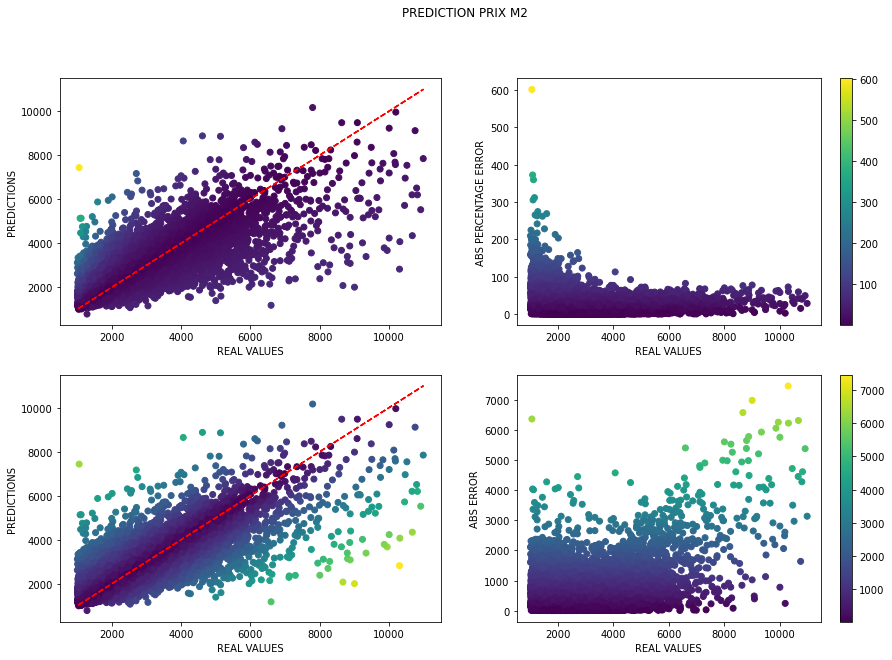

In [23]:
mape = np.abs((predicted - Y_test)/Y_test)*100

plt.figure(figsize = (15,10))
plt.subplot(2,2,1)
plt.scatter(Y_test,predicted,c= mape)
plt.plot(Y_test,Y_test,'r--')
plt.xlabel('REAL VALUES')
plt.ylabel('PREDICTIONS')
plt.subplot(2,2,2)
mape = np.abs((predicted - Y_test)/Y_test)*100
plt.scatter(Y_test,mape,c= mape)
plt.xlabel('REAL VALUES')
plt.ylabel('ABS PERCENTAGE ERROR')

plt.colorbar()


mae = np.abs(predicted - Y_test)

plt.subplot(2,2,3)
plt.scatter(Y_test,predicted,c= mae)
plt.plot(Y_test,Y_test,'r--')
plt.xlabel('REAL VALUES')
plt.ylabel('PREDICTIONS')
plt.subplot(2,2,4)
plt.scatter(Y_test,mae,c= mae)
plt.xlabel('REAL VALUES')
plt.ylabel('ABS ERROR')



plt.suptitle('PREDICTION PRIX M2')
plt.colorbar()

Mean absolute percentage error = 19.560454431124548
Median absolute percentage error = 13.009908163759517


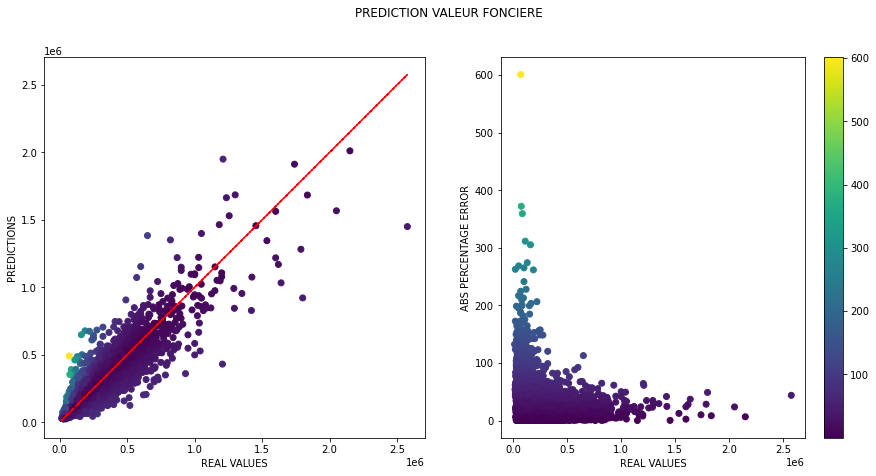

In [24]:
mape = np.abs((valeur_fonciere - prediction_vf)/valeur_fonciere)*100

evaluate_model(valeur_fonciere,prediction_vf)

plt.figure(figsize = (15,7))
plt.subplot(1,2,1)
plt.scatter(valeur_fonciere,prediction_vf,c= mape)
plt.plot(valeur_fonciere,valeur_fonciere,'r--')
plt.xlabel('REAL VALUES')
plt.ylabel('PREDICTIONS')
plt.subplot(1,2,2)

plt.scatter(valeur_fonciere,mape,c= mape)
plt.xlabel('REAL VALUES')
plt.ylabel('ABS PERCENTAGE ERROR')
plt.suptitle('PREDICTION VALEUR FONCIERE')
plt.colorbar()

# Spatial distribution of the error : 

In [25]:
error = mape

hmap = folium.Map(location= center, zoom_start=10)

df_test = df[df.index.isin(index_test)] 
nb_plots = 1e3

max_error = max(error)
min_error = min(error)
mean_error = np.mean(error)
med_error = np.median(error)
colormap = cm.LinearColormap(colors=['lightblue','red'], index = [min_error,max_error],
                             vmin=min_error,vmax=max_error)



lat = list(df_test.reset_index().loc[:nb_plots].latitude_real)
lon = list(df_test.reset_index().loc[:nb_plots].longitude_real)
price = list(error)


for loc, p in tqdm(zip(zip(lat, lon), error)):
    folium.Circle(
        location=loc,
        radius=p,
        fill=True,
        color=colormap(p),
        fill_opacity=p/max_error).add_to(hmap)
    
hmap.add_child(colormap)

display(hmap)

1001it [00:00, 17706.59it/s]


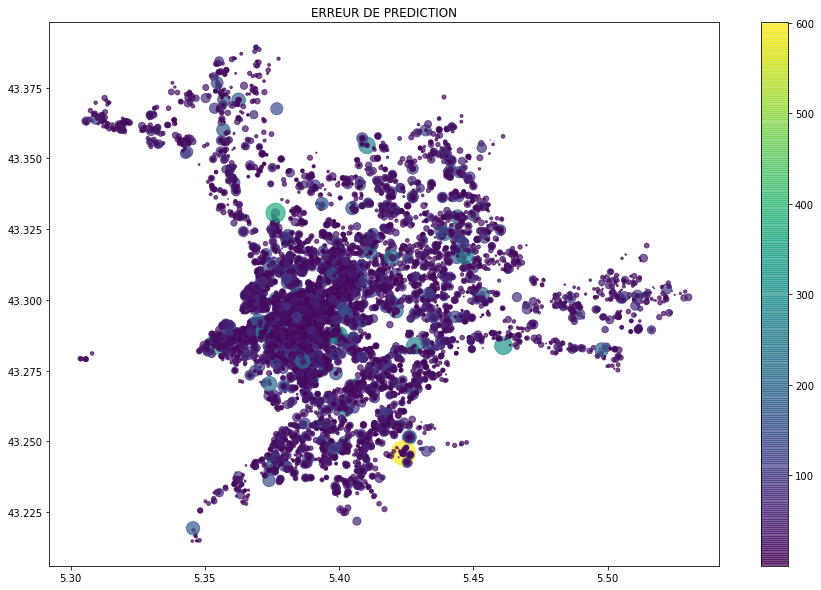

In [26]:
plt.figure(figsize = (15,10))
plt.scatter(df_test.longitude_real.values,df_test.latitude_real.values, c = error,s=error,alpha=0.7)
plt.colorbar()
plt.title('ERREUR DE PREDICTION')
plt.show()

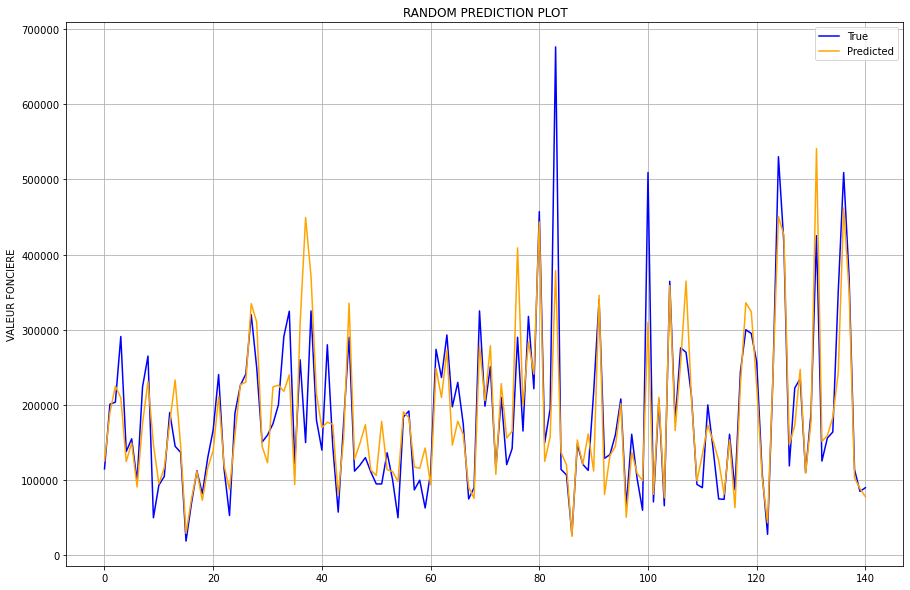

In [27]:
plt.figure(figsize=(15,10))
n = len(Y_test)
number = int(n/100)
array = np.arange(n)
shuffle(array)

i = randint(0,n-number)

prediction = prediction_vf
prediction_plot = []
true_plot = []

for indice in array[i:i+number]:
    true_plot.append(valeur_fonciere.values[indice])
    prediction_plot.append(prediction.values[indice])
    

plt.plot(range(number),true_plot,'b',label='True')
plt.plot(range(number),prediction_plot,'orange',label='Predicted')
plt.grid()
plt.title('RANDOM PREDICTION PLOT')
plt.ylabel('VALEUR FONCIERE')
plt.legend()

In [28]:
n_repeats = 5

feature_importances = permutation_importance(
    MODEL, X_test, Y_test, n_repeats=n_repeats
)

In [29]:
sorted_idx = feature_importances.importances_mean.argsort()[::-1]
names = X_test.columns.copy()

for i in range(len(names)):
    features = feature_importances.importances[sorted_idx].T[:,i]
    series = pd.Series(features)
    if i == 0 :
        dfa = pd.DataFrame(series,columns = ['Importance'])
        dfa['Features'] = np.array(names)[sorted_idx][i]
    else : 
        df2 = pd.DataFrame(series,columns = ['Importance'])
        df2['Features'] = np.array(names)[sorted_idx][i]
        dfa = pd.concat([dfa,df2])

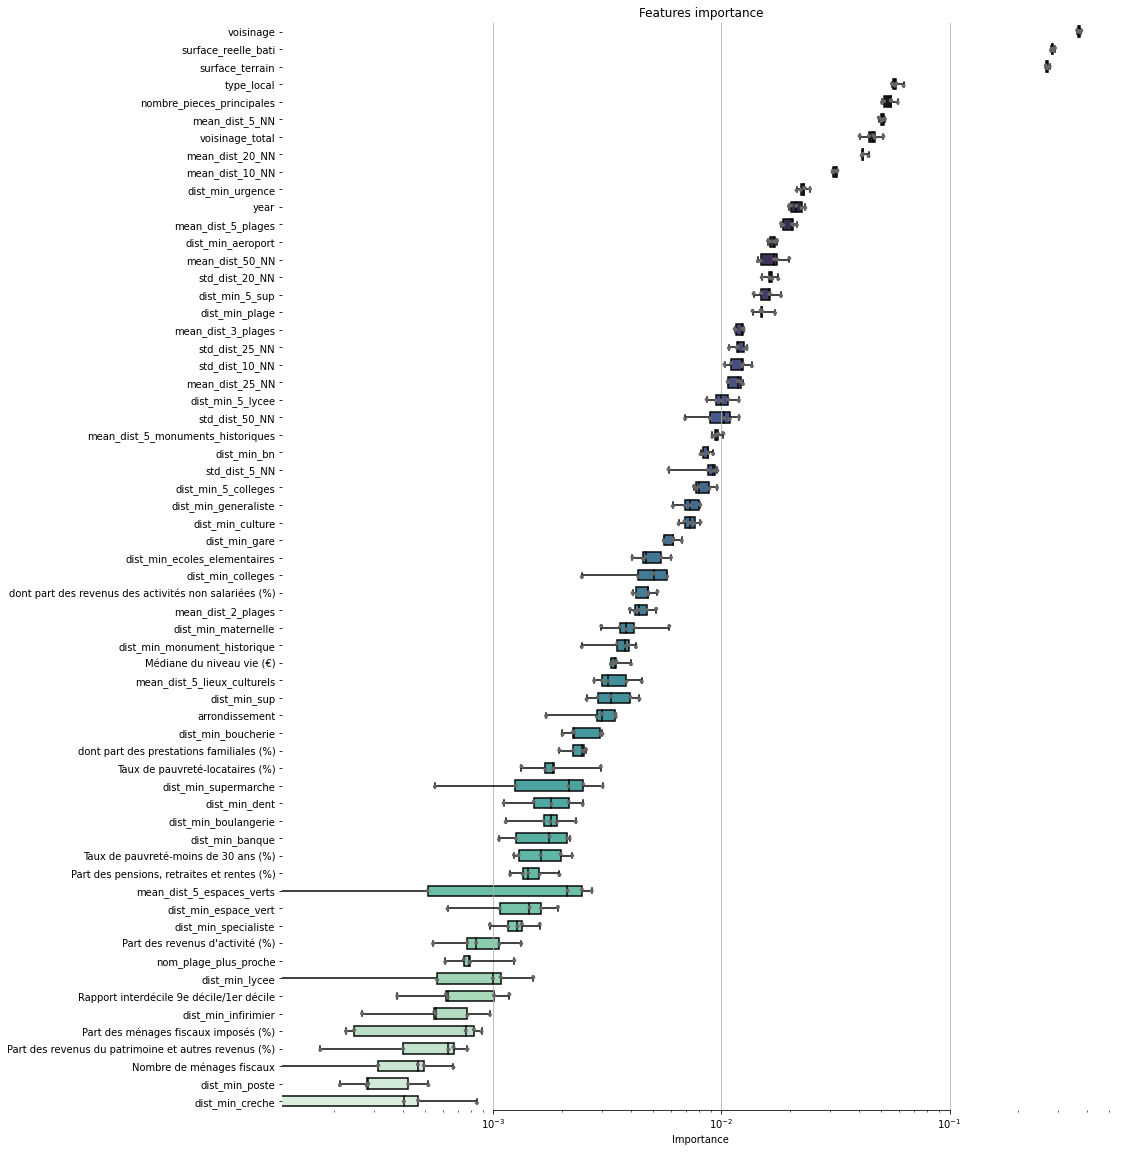

In [30]:
# Plot the orbital period with horizontal boxes

f, ax = plt.subplots(figsize=(15,20))
ax.set_xscale("log")
sns.boxplot(x='Importance', y='Features',data=dfa,
            whis=[0, 100], width=.6, palette="mako")


sns.stripplot(x='Importance', y='Features',data=dfa,
              size=4, color=".4", linewidth=0)

# Tweak the visual presentation
ax.xaxis.grid(True)
ax.set(ylabel="")
sns.despine(trim=True, left=True)
ax.set_title('Features importance');

# Neural Network

In [31]:
X_pre_train = X_train.copy()
X_pre_test = X_test.copy()
Y_train = prix_m2_train
Y_test = prix_m2_test

In [32]:
X_train_keras = preprocessor.transform(X_pre_train[categorical_features + quantitative_features])
X_test_keras = preprocessor.transform(X_pre_test[categorical_features + quantitative_features])

In [33]:
callback = EarlyStopping(patience=15,restore_best_weights = True)

In [34]:
# Decalaration of our neural network architechture. We use batchnormalization layers as well 
# as dropout to prevent overfitting
def create_network():
    model = Sequential()
    model.add(Dense(16, activation='relu',input_shape = (X_train_keras.shape[1],)))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(64,activation='relu'))
    model.add(Dense(32, activation='selu'))
    model.add(Dense(16, activation='selu'))
    model.add(Dense(8, activation='selu'))
    model.add(Dense(1, activation='linear'))

    model.compile(optimizer = 'adam', loss = 'mean_absolute_error')

    return model

In [35]:
keras_regressor = KerasRegressor(build_fn=create_network, epochs=1500,verbose=1,batch_size = 128)

In [36]:
keras_regressor.fit(X_train_keras,Y_train,callbacks=[callback],validation_split=0.2)

Train on 45210 samples, validate on 11303 samples
Epoch 1/1500
45210/45210 [==============================] - 3s 56us/step - loss: 1350.8636 - val_loss: 688.1915
Epoch 2/1500
45210/45210 [==============================] - 2s 42us/step - loss: 630.6495 - val_loss: 603.2165
Epoch 3/1500
45210/45210 [==============================] - 2s 50us/step - loss: 590.3714 - val_loss: 587.8652
Epoch 4/1500
45210/45210 [==============================] - 2s 53us/step - loss: 581.3704 - val_loss: 582.0211
Epoch 5/1500
45210/45210 [==============================] - 3s 61us/step - loss: 575.4554 - val_loss: 579.3761
Epoch 6/1500
45210/45210 [==============================] - 2s 41us/step - loss: 572.0302 - val_loss: 577.5492
Epoch 7/1500
45210/45210 [==============================] - 2s 50us/step - loss: 569.4368 - val_loss: 573.4131
Epoch 8/1500
45210/45210 [==============================] - 2s 40us/step - loss: 566.6462 - val_loss: 572.7843
Epoch 9/1500
45210/45210 [==============================] - 2

45210/45210 [==============================] - 2s 42us/step - loss: 537.4332 - val_loss: 552.9585
Epoch 74/1500
45210/45210 [==============================] - 2s 41us/step - loss: 537.0887 - val_loss: 551.7922
Epoch 75/1500
45210/45210 [==============================] - 2s 40us/step - loss: 536.9135 - val_loss: 552.9151
Epoch 76/1500
45210/45210 [==============================] - 2s 39us/step - loss: 536.8786 - val_loss: 550.5023
Epoch 77/1500
45210/45210 [==============================] - 2s 37us/step - loss: 536.1375 - val_loss: 551.2444
Epoch 78/1500
45210/45210 [==============================] - 2s 38us/step - loss: 536.4189 - val_loss: 550.1481
Epoch 79/1500
45210/45210 [==============================] - 2s 39us/step - loss: 535.2549 - val_loss: 552.3598
Epoch 80/1500
45210/45210 [==============================] - 2s 41us/step - loss: 535.0300 - val_loss: 550.5010
Epoch 81/1500
45210/45210 [==============================] - 2s 46us/step - loss: 535.3399 - val_loss: 551.6644
Epoch 

In [37]:
prediction = keras_regressor.predict(X_test_keras)
evaluate_model(prediction,Y_test)

14129/14129 [==============================] - 0s 16us/step
Mean absolute percentage error = 19.26931666067957
Median absolute percentage error = 13.669815344845308


In [38]:
prediction_vf = prediction*X_test.surface_reelle_bati
evaluate_model(prediction_vf,vf_test)

Mean absolute percentage error = 19.26931666067957
Median absolute percentage error = 13.669815344845313


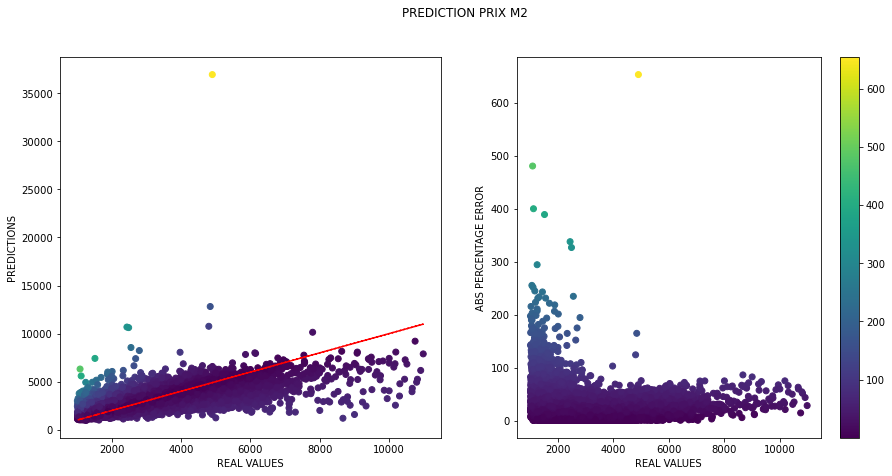

In [39]:
mape = np.abs((Y_test-prediction)/Y_test)*100

plt.figure(figsize = (15,7))
plt.subplot(1,2,1)
plt.scatter(Y_test,prediction,c= mape)
plt.plot(Y_test,Y_test,'r--')
plt.xlabel('REAL VALUES')
plt.ylabel('PREDICTIONS')
plt.subplot(1,2,2)
mape = np.abs((prediction - Y_test)/Y_test)*100
plt.scatter(Y_test,mape,c= mape)
plt.xlabel('REAL VALUES')
plt.ylabel('ABS PERCENTAGE ERROR')
plt.suptitle('PREDICTION PRIX M2')
plt.colorbar()

In [40]:
(5000 - 25000)/5000

-4.0

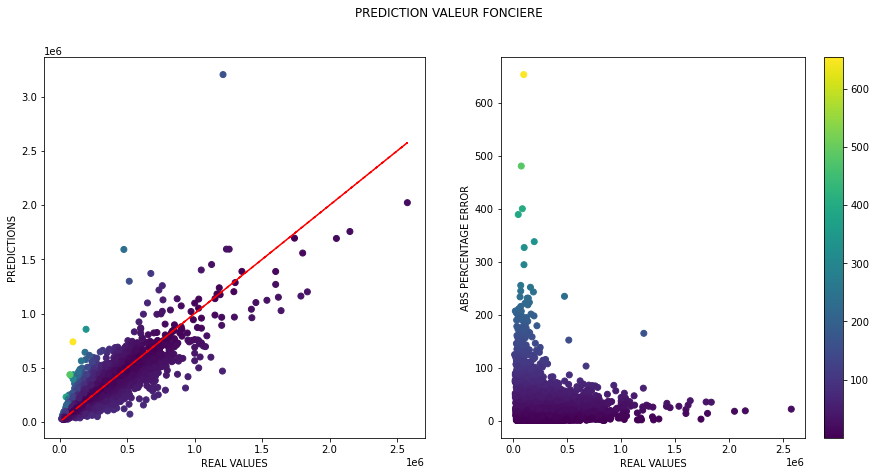

In [41]:
mape = np.abs((vf_test - prediction_vf)/vf_test)*100

plt.figure(figsize = (15,7))
plt.subplot(1,2,1)
plt.scatter(vf_test,prediction_vf,c= mape)
plt.plot(vf_test,vf_test,'r--')
plt.xlabel('REAL VALUES')
plt.ylabel('PREDICTIONS')
plt.subplot(1,2,2)

plt.scatter(vf_test,mape,c= mape)
plt.xlabel('REAL VALUES')
plt.ylabel('ABS PERCENTAGE ERROR')
plt.suptitle('PREDICTION VALEUR FONCIERE')
plt.colorbar();

# MIXED MODEL 

In [42]:
mixed = np.average([prediction,predicted],axis=0,weights=[0.5,0.5])
evaluate_model(mixed,Y_test)

Mean absolute percentage error = 17.975613746591737
Median absolute percentage error = 13.011640696979043


In [43]:
part_keras = np.linspace(0,1,101)
list_mape = []
min_loss = np.inf 
best_tradeoff = 0
best_mixed = mixed

for i in part_keras : 
    mixed = np.average([prediction,predicted],axis=0,weights=[i,1-i])
    mae = np.mean(np.abs(mixed-Y_test))
    list_mape.append(mae)
    if mae < min_loss : 
        best_tradeoff = i 
        min_loss = mae
        best_mixed = mixed
        

Text(0.5, 1.0, 'BEST PART KERAS : 0.35000000000000003')

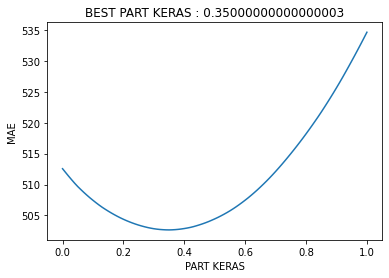

In [44]:
plt.figure()
plt.plot(part_keras,list_mape)
plt.ylabel('MAE')
plt.xlabel('PART KERAS')
plt.title('BEST PART KERAS : {}'.format(best_tradeoff))

In [45]:
evaluate_model(best_mixed,Y_test)

Mean absolute percentage error = 17.867814185045212
Median absolute percentage error = 12.868800619011367


In [46]:
Boundary = 20

ap_error = (np.abs(Y_test-best_mixed)/Y_test)*100
print("Prediction with less than {}% error represents {}% of predictions.".format(Boundary,(1 - (len(Y_test) - sum(ap_error < Boundary))/len(Y_test))*100))

Prediction with less than 20% error represents 68.03736994833322% of predictions.


# Make the true training of the two models, save optimal tradeoff

In [47]:
X = df[categorical_features + quantitative_features]
Y = df.Prix_m2_bati

In [48]:
preprocessor = ColumnTransformer(
        [
            ("preprocessor_cat",OneHotEncoder(handle_unknown = 'ignore'),categorical_features),
            ("preprocessor_quant",StandardScaler(),quantitative_features)
            
        ], remainder = 'drop')

In [49]:
MODEL = Pipeline(
        [
            ("preprocessor",preprocessor),
            ("regressor",LGBMRegressor(learning_rate=0.2,n_estimators=1000))
        ])

In [50]:
MODEL.fit(X,Y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('preprocessor_cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['nombre_pieces_principales',
                                                   'type_local', 'year',
                                                   'arrondissement',
                                                   'nom_plage_plus_proche']),
                                                 ('preprocessor_quant',
                                                  StandardScaler(),
                                                  ['surface_reelle_bati',
                                                   'surface_terrain',
                                                   'dist_min_lycee',
                                                   'dist_min_5_lycee',
                                                   'dist_min_maternell...
         

In [51]:
X_keras = preprocessor.transform(X)

In [52]:
callback = EarlyStopping(patience=15,restore_best_weights = True)

In [53]:
# Decalaration of our neural network architechture. We use batchnormalization layers as well 
# as dropout to prevent overfitting
def create_network():
    model = Sequential()
    model.add(Dense(16, activation='relu',input_shape = (X_keras.shape[1],)))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(64,activation='relu'))
    model.add(Dense(32, activation='selu'))
    model.add(Dense(16, activation='selu'))
    model.add(Dense(8, activation='selu'))
    model.add(Dense(1, activation='linear'))

    model.compile(optimizer = 'adam', loss = 'mean_absolute_error')

    return model

In [54]:
keras_regressor = KerasRegressor(build_fn=create_network, epochs=1500,verbose=1,batch_size = 128)

In [55]:
keras_regressor.fit(X_keras,Y,callbacks=[callback],validation_split=0.2)

Train on 56513 samples, validate on 14129 samples
Epoch 1/1500
56513/56513 [==============================] - 3s 50us/step - loss: 1131.7910 - val_loss: 694.6928
Epoch 2/1500
56513/56513 [==============================] - 2s 43us/step - loss: 585.0539 - val_loss: 669.8767
Epoch 3/1500
56513/56513 [==============================] - 2s 41us/step - loss: 568.9979 - val_loss: 669.1529
Epoch 4/1500
56513/56513 [==============================] - 2s 41us/step - loss: 561.1485 - val_loss: 662.8337
Epoch 5/1500
56513/56513 [==============================] - 2s 38us/step - loss: 555.7859 - val_loss: 652.1660
Epoch 6/1500
56513/56513 [==============================] - 2s 36us/step - loss: 551.2125 - val_loss: 645.1138
Epoch 7/1500
56513/56513 [==============================] - 2s 42us/step - loss: 546.6710 - val_loss: 661.5382
Epoch 8/1500
56513/56513 [==============================] - 2s 42us/step - loss: 545.4254 - val_loss: 643.2506
Epoch 9/1500
56513/56513 [==============================] - 2

# Saving models

In [56]:
filename = './models/Pipeline_LGBM_{}.sav'.format(DEPARTMENT)
pickle.dump(MODEL, open(filename, 'wb'))

In [57]:
filename = './models/preprocessor_keras_{}.sav'.format(DEPARTMENT)
pickle.dump(preprocessor, open(filename, 'wb'))

In [58]:
filename = './models/keras_{}.h5'.format(DEPARTMENT)
keras_regressor.model.save(filename)